## Data Prep for CNN

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [42]:
path = "/Users/nicolasoederlin/code/jhupiterz/SafeSeizure/data/dataset/sensor0"

In [43]:
batch_size = 32
img_height = 180
img_width = 180

In [44]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 128 files belonging to 2 classes.
Using 103 files for training.


In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 128 files belonging to 2 classes.
Using 25 files for validation.


In [46]:
class_names = train_ds.class_names
print(class_names)

['interictal_images', 'preictal_images']


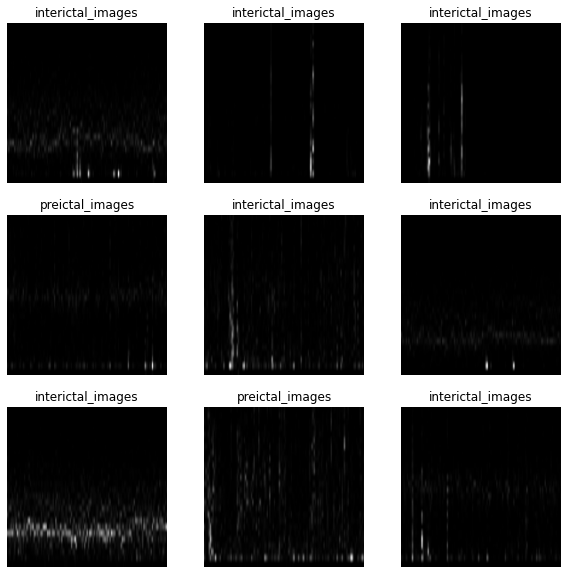

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Normalization 
pixels values are now in `[0,1]`

In [49]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.9472219


## Model 1 test

In [79]:

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='softmax'),
])

In [80]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [81]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 64800)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

In [82]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
4/4 [==============================] - 2s 279ms/step - loss: 3.8706 - accuracy: 0.4123 - val_loss: 1.3011 - val_accuracy: 0.5200
Epoch 2/10
4/4 [==============================] - 1s 270ms/step - loss: 0.8679 - accuracy: 0.7620 - val_loss: 0.7781 - val_accuracy: 0.5200
Epoch 3/10
4/4 [==============================] - 1s 261ms/step - loss: 0.3377 - accuracy: 0.8150 - val_loss: 0.4381 - val_accuracy: 0.9200
Epoch 4/10
4/4 [==============================] - 1s 257ms/step - loss: 0.3161 - accuracy: 0.8522 - val_loss: 1.1733 - val_accuracy: 0.5200
Epoch 5/10
4/4 [==============================] - 1s 240ms/step - loss: 0.2395 - accuracy: 0.8562 - val_loss: 0.3595 - val_accuracy: 0.9200
Epoch 6/10
4/4 [==============================] - 1s 259ms/step - loss: 0.2813 - accuracy: 0.8708 - val_loss: 1.2898 - val_accuracy: 0.6000
Epoch 7/10
4/4 [==============================] - 1s 298ms/step - loss: 0.1708 - accuracy: 0.9015 - val_loss: 0.6326 - val_accuracy: 0.8400
Epoch 8/10
4/4 [====

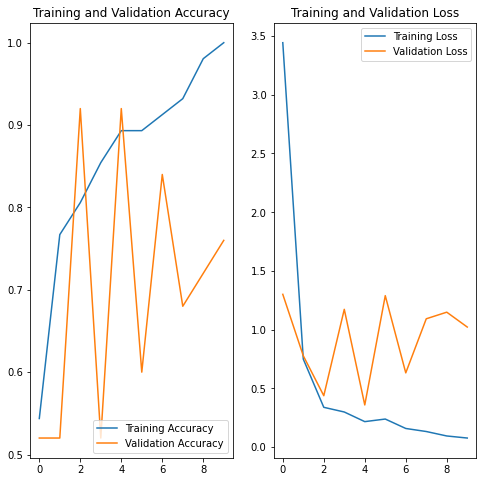

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 2 test

In [84]:
model2 = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (img_height,img_width,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [85]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 97200)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               12441728  
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 12,441,857
Trainable params: 12,441,857
Non-trainable params: 0
_________________________________________________________________


In [86]:
model2.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_test, Y_test))

In [87]:
epochs=10
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
4/4 [==============================] - 1s 124ms/step - loss: 262.8931 - accuracy: 0.6887 - val_loss: 214.1217 - val_accuracy: 0.6400
Epoch 2/10
4/4 [==============================] - 1s 98ms/step - loss: 104.7547 - accuracy: 0.8091 - val_loss: 298.7211 - val_accuracy: 0.7200
Epoch 3/10
4/4 [==============================] - 1s 96ms/step - loss: 12.6318 - accuracy: 0.9179 - val_loss: 207.5463 - val_accuracy: 0.8000
Epoch 4/10
4/4 [==============================] - 1s 97ms/step - loss: 201.7150 - accuracy: 0.6825 - val_loss: 271.2714 - val_accuracy: 0.7200
Epoch 5/10
4/4 [==============================] - 1s 94ms/step - loss: 2.3488 - accuracy: 0.9842 - val_loss: 711.4244 - val_accuracy: 0.5600
Epoch 6/10
4/4 [==============================] - 1s 98ms/step - loss: 61.1775 - accuracy: 0.8288 - val_loss: 776.5407 - val_accuracy: 0.6400
Epoch 7/10
4/4 [==============================] - 0s 94ms/step - loss: 54.9383 - accuracy: 0.8656 - val_loss: 578.9714 - val_accuracy: 0.7200
Epo

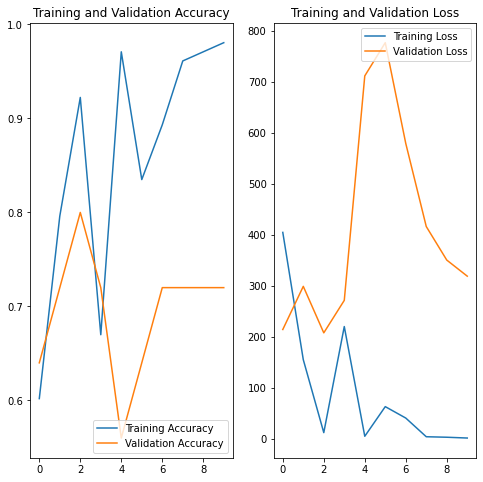

In [88]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()